### Convex Quadratic Optimization
$$\min_{x \in R^d} \frac 12 x^T Q x + c^T x$$
subject to
$$l^c \le Ax \le u^c,$$
$$l^x \le x \le u^x$$

### Slab SVM
Let $K \in R^{~n~x~n}$ and $K_{ij} = \texttt{Kernel}(x_i, x_j)$
$$\min_{\alpha \in R^d} \frac 12 \alpha^T K \alpha + [-\delta...-\delta] \alpha$$
subject to
$$1\le [1~...~1]~\alpha \le 1,$$
$$\frac {-1}{vm} \le \alpha_i \le \frac {1}{vm}$$
Evaluation
$$ \sum_i \alpha_i k(x_i,x) - \rho $$

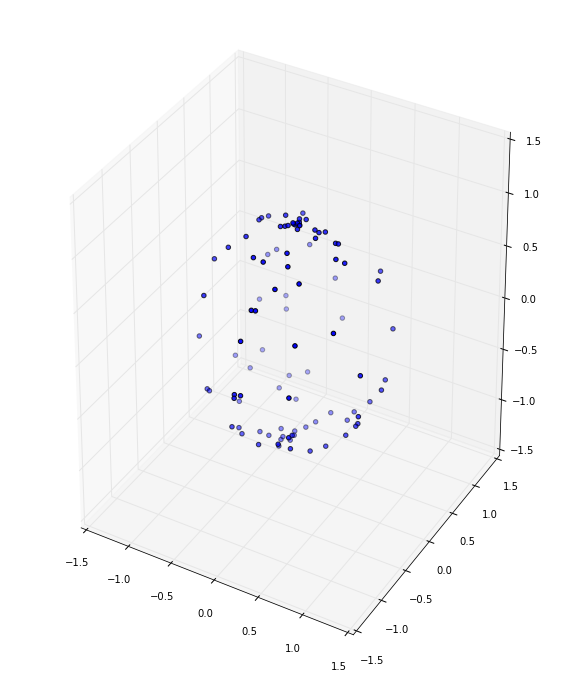

qp_solve: 0.182929039001


In [28]:
%matplotlib inline

import numpy as np
from numpy import linalg, random, ones, zeros
from numpy.linalg import norm
from sklearn.cross_validation import train_test_split
import mosek
import math
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import sys
import time 
from collections import namedtuple

v=.00001
delta = 0.0
sigma = 100
rho = 1.0
timer_thresh = .1
x=np.zeros((0))
m=len(x)
points_count = 100
points_std_from_surface = 0

# Define a stream printer to grab output from MOSEK
def streamprinter(text):
#     sys.stdout.write(text)
#     sys.stdout.flush()
    pass

def kernel(x1,x2):
    return math.exp(-1*math.pow(linalg.norm(x1-x2),2)/(2*math.pow(sigma,
                                                                  2)))

def kernel_vect(x_list,x2):
    return np.exp(-1*np.power(norm(x_list-x2,axis=1),
                              2 )/(2*math.pow(sigma, 2)))

def f(x_test, beta):
    start = time.time()
    
    w = np.dot(beta,kernel_vect(x,x_test))

#     w = 0
#     for i in range(len(x)):
#         w += beta[i]*kernel(x[i],x_test)
    
#     assert np.sum(np.absolute(w-w0)) < 0.000001
    
    end = time.time()
    if end - start > timer_thresh:
        print 'f:',end - start
    return w

def get_data_points():
    start = time.time()
    points = random.random((points_count,2))*2*np.pi

    x = np.zeros((len(points),3))
    for p in range(len(points)):
        if points_std_from_surface > 0:
            r = random.normal(loc=1,scale=points_std_from_surface)
        else:
            r = 1
        z_cord = r * np.sin(points[p][1])

        r_temp = r * np.cos(points[p][1])
        y_cord = r_temp * np.sin(points[p][0])
        x_cord = r_temp * np.cos(points[p][0])

        x[p] = np.asarray([x_cord, y_cord, z_cord])
        assert x_cord**2 + y_cord**2 + z_cord**2 - r**2 < .00001
            
    end = time.time()
    if end - start > timer_thresh:
        print 'get_data_points:',end - start
    return x

def optimize(task):
    start = time.time()
    
    task.optimize()
    
    end = time.time()
    if end - start > timer_thresh:
        print 'optimize:',end - start

def qp_solve():
    start = time.time()
    # Open MOSEK and create an environment and task
    # Make a MOSEK environment
    env = mosek.Env ()
    # Attach a printer to the environment
    env.set_Stream (mosek.streamtype.log, streamprinter)
    # Create a task
    task = env.Task()
    task.set_Stream (mosek.streamtype.log, streamprinter)
    # Set up and input bounds and linear coefficients
    bkc   = [ mosek.boundkey.fx]
    blc   = [ 1.0 ]
    buc   = [ 1.0 ]

    bkx=[]
    for i in range(m):
        bkx.append(mosek.boundkey.ra)
    bux=(ones((m))) * (1/(v*m))
    blx=(ones((m))) * (-1/(v*m))
    c=(delta*ones((m)))

    numvar = len(bkx)
    numcon = len(bkc)

    # Append 'numcon' empty constraints.
    # The constraints will initially have no bounds.
    task.appendcons(numcon)

    # Append 'numvar' variables.
    # The variables will initially be fixed at zero (x=0).
    task.appendvars(numvar)

    for j in range(numvar):
        # Set the linear term c_j in the objective.
        task.putcj(j,c[j])
        # Set the bounds on variable j
        # blx[j] <= x_j <= bux[j]
        task.putbound(mosek.accmode.var,j,bkx[j],blx[j],bux[j])

        # Input i, j of A
        task.putaij(0, j, 1)

    for i in range(numcon):
        task.putbound(mosek.accmode.con,i,bkc[i],blc[i],buc[i])

    # Input the objective sense (minimize/maximize)
    task.putobjsense(mosek.objsense.minimize)

    # Set up and input quadratic objective
    for i in range(m):
        for j in range(i+1):
            task.putqobjij(i,j,kernel(x[i],x[j]))

    # Optimize
    optimize(task)

    # Print a summary containing information
    # about the solution for debugging purposes
    task.solutionsummary(mosek.streamtype.msg)

    prosta = task.getprosta(mosek.soltype.itr)
    solsta = task.getsolsta(mosek.soltype.itr)

    # Output a solution
    alpha = zeros(numvar, float)
    task.getxx(mosek.soltype.itr, alpha)

    # if solsta == mosek.solsta.optimal or solsta == \
    #  mosek.solsta.near_optimal:
    #     print("Optimal solution: %s" % alpha)
    # elif solsta == mosek.solsta.dual_infeas_cer:
    #     print("Primal or dual infeasibility.\n")
    # elif solsta == mosek.solsta.prim_infeas_cer:
    #     print("Primal or dual infeasibility.\n")
    # elif solsta == mosek.solsta.near_dual_infeas_cer:
    #     print("Primal or dual infeasibility.\n")
    # elif  solsta == mosek.solsta.near_prim_infeas_cer:
    #     print("Primal or dual infeasibility.\n")
    # elif mosek.solsta.unknown:
    #     print("Unknown solution status")
    # else:
    #     print("Other solution status")

    end = time.time()
    if end - start > timer_thresh:
        print 'qp_solve:',end - start

    return alpha
    
    
x = get_data_points()        
m = len(x)
        
fig = plt.figure(figsize=(10, 12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:,0],x[:,1],x[:,2])
plt.show()

alpha = qp_solve()


In [29]:
grid_steps = 25

def pop_data_grid(beta,rho):
    start = time.time()
    data = np.zeros((grid_steps,grid_steps,grid_steps))

    x0_range = np.linspace(-3, 3, grid_steps)
    x1_range = np.linspace(-3, 3, grid_steps)
    x2_range = np.linspace(-3, 3, grid_steps)
    end = time.time()
    if end - start > timer_thresh:
        print 'alloc mem:',end - start

    for i in range(grid_steps):
        for j in range(grid_steps):
            for k in range(grid_steps):
                data[i,j,k] = f(np.asarray([x0_range[i],
                                x1_range[j],
                                x2_range[k]]), beta) - rho
                
    end = time.time()
    if end - start > timer_thresh:
        print 'pop_data_grid:',end - start
    return data

def proc_data(beta,data):
    start = time.time()

    print 'delta',delta
    print 'np.abs(data - delta) < .1 -> ',(np.where(np.abs(data - delta) < .1)[0].shape)
    print 'np.abs(data - delta) < .01 -> ',(np.where(np.abs(data - delta) < .01)[0].shape)
    print 'np.abs(data - delta) < .001 -> ',(np.where(np.abs(data - delta) < .001)[0].shape)
    print 'np.abs(data - delta) < .0001 -> ',(np.where(np.abs(data - delta) < .0001)[0].shape)
    print 'data < delta -> ',(np.where(data < delta )[0].shape)
    print 'data > delta -> ',(np.where(data > delta )[0].shape)
    print 'data < 0 -> ',(np.where( data < 0)[0].shape)
    print 'data == 0 -> ',(np.where( data == 0)[0].shape)
    print 'data > 0 -> ',(np.where( data > 0)[0].shape)
    print 'min -> ',(np.amin( data ))
    print 'max -> ',(np.amax( data ))
#     print 'data:',data
    
    end = time.time()
    if end - start > timer_thresh:
        print 'proc_results:',end - start

losses = []
for i in range(len(x)):
    losses.append(f(x[i], alpha))
losses = np.asarray(losses)
rho = (np.amax(losses)+np.amin(losses))/2

# proc_data(alpha,(losses))

data = pop_data_grid(alpha,rho)

# proc_data(alpha,data)


pop_data_grid: 0.65605711937


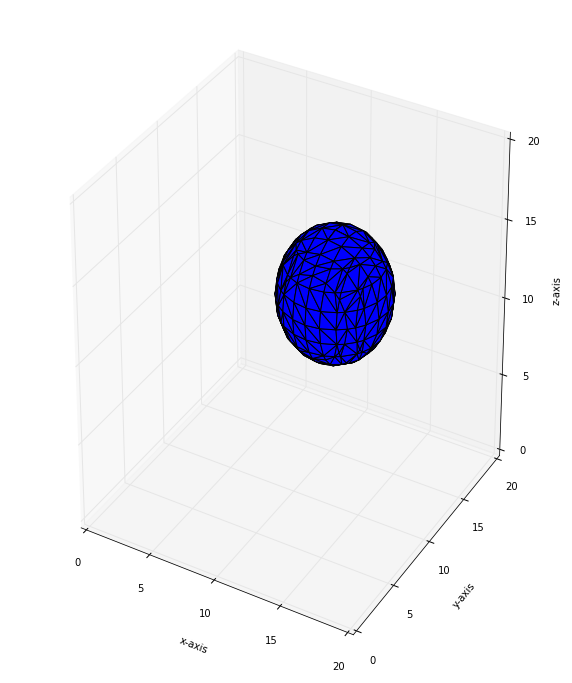

In [31]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sys
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from skimage import measure
from skimage.draw import ellipsoid

# Use marching cubes to obtain the surface mesh of these ellipsoids
verts, faces = measure.marching_cubes(data, 0)

# Display resulting triangular mesh using Matplotlib. This can also be done
# with mayavi (see skimage.measure.marching_cubes docstring).
fig = plt.figure(figsize=(10, 12))
ax = fig.add_subplot(111, projection='3d')

# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(verts[faces])
ax.add_collection3d(mesh)

ax.set_xlabel("x-axis")
ax.set_ylabel("y-axis")
ax.set_zlabel("z-axis")

ax.set_xlim(-0, 20)  
ax.set_ylim(-0, 20)  
ax.set_zlim(-0, 20)  

plt.show()
